In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt


加载每天我收到的短信数量数据。

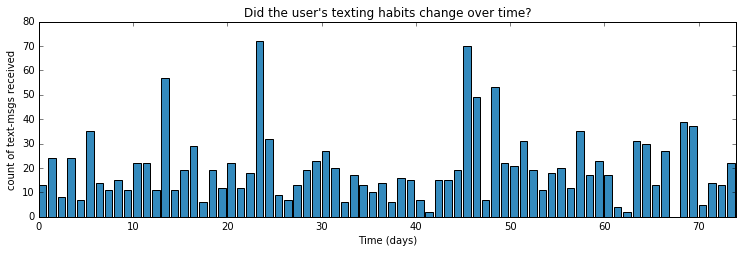

In [3]:
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

观察上面的数据，你可以说出在不同的时期发生了行为的变化吗？

正如之前讨论过的，对于这种count data，Poisson分布很适合拟合它们。我们用$C_i$来表示第$i$天收到的短信数量。

$$ C_i \sim \text{Poisson}(\lambda)$$

观察图，我们发现在稍后的时期，收到短信的频率会增加，这等于是说$\lambda$在某个时间点值变大了。（更高的$\lambda$值表明有更高的概率出现更多的短信。）

我们如何用数学公式表示这一现象呢？假设那个时间点用$\tau$表示，在$\tau$之前，我们的模型是$\lambda_1$，在$\tau$之后，我们的模型是$\lambda_2$。我们称$\tau$为*switchpoingt*。

$$
\lambda = 
\begin{cases}
\lambda_1 & \text{if} t \lt \tau \cr
\lambda_2 & \text{if} t \ge \tau
\end{cases}
$$

在实际中，如果没有发生频率突然改变，那么$\lambda_1 = lambda_2$，则两个$\lambda$的后验概率分布相同。

我们如何对未知的$\lambda$建模呢？对$\lambda$而言，什么是好的先验假设呢？因为$\lambda$可以是任何正实数，而几何分布可以提供这样一个连续的正实数分布，所以几何分布会是一个不错的假设。但是，几何分布同样也有自己的参数$\alpha$，所以对我们的模型来说，还需要引入$\lambda$。

\begin{align}
\lambda_1 \sim \text{Exp}(\alpha) \\
\lambda_2 \sim \text{Exp}(\alpha)
\end{align}

在我们的模型里，$\alpha$被称为超参数或父变量。用术语讲，就是它影响其他参数。$\alpha$的初始假设对模型的影响并不强烈，所以我们需要一个灵活的选择。一个实用的经验法则是设置几何分布的参数$\alpha$等于观测数据平均数的倒数。

$$ \frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; | \; \alpha] = \frac{1}{\alpha}$$

实际上，可以对超参数$\alpha$优化，即为每个$\lambda$指定一个超参数$\alpha$。这里我们模型的两个$\lambda$公用一个$\alpha$。

那$\tau$应该如何假设它的值呢？因为存在数据存在噪音，所以某天当$\tau$发生时，这很难对$\tau$给出一个合理的先验概率假设。取而代之，我们给$\tau$一个uniform prior belief for every possible day。用公式来说就是：

\begin{align}
&\tau \sim \text{DiscreteUniform(1,70)} \\
&\Rightarrow P(\tau=k) = \frac{1}{70}
\end{align}

对于模型的所有未知变量而言，它们的先验分布长什么样？坦白讲，这无所谓。因为对于参数的先验分布实际上是很扯淡的，我们真正关心的是经过观察数据的校正，得到的模型参数的后验概率分布。

In [4]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0 / count_data.mean()
    
    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    
    tau = pm.DiscreteUniform('tau', lower=0, upper=n_count_data - 1)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


上面的代码创建了随机变量$\lambda_1$,$\lambda_2$,$\tau$，它们都是随机变量生成器。

In [5]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(idx < tau, lambda_1, lambda_2)

上面的代码创建了一个新方程`lambda_`，但是实际上我们可以把它看做一个随机变量：来自上面随机数生成器的随机变量$\lambda$。`lambda_`被赋值为`lambda_1`还是`lambda_2`是由`tau`决定的。条件为真时，`lambda_` are `lambda_1` else `lambda_2`.

因为`lambda_1`,`lambda_2`,`tau`都是随机变量，所以`lambda_`也是随机变量。我们到目前为止还没有**固定**任何变量的取值。

In [6]:
with model:
    observation = pm.Poisson('obs', lambda_, observed=count_data)

In [10]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:37<00:00, 44.50it/s]


上面的代码实现了Markov Chain Monte Carlo(MCMC)技术。这个技术返回上千个从随机变量$\lambda_1$,$\lambda_2$,$\tau$采样的值。我们可以画图看看这三个随机变量的分布长什么样子。

In [11]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

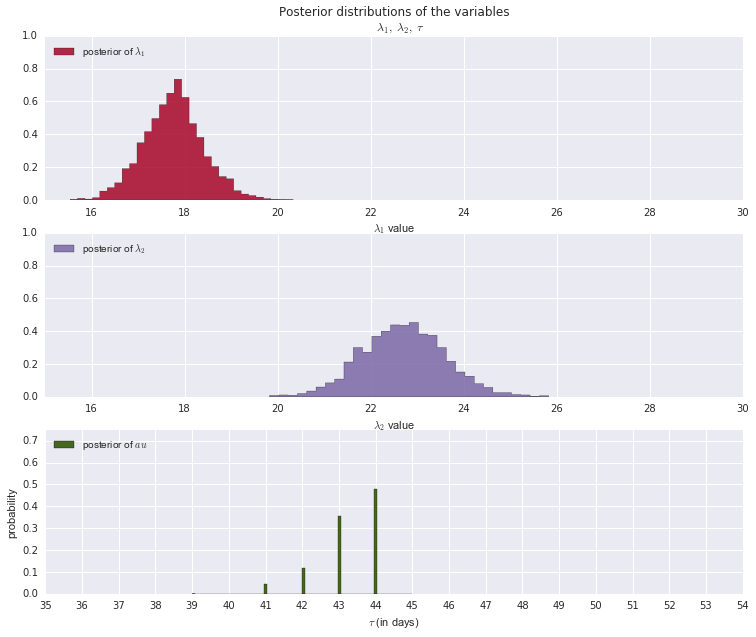

In [22]:
import seaborn as sns

figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
        label='posterior of $\tau$',
        color='#456821', weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

### 解释MCMC

从结果我们可以看出我们对模型参数估计值的不确定性：参数的分布越分散，越不确定。我们还可以看出合理的参数$\lambda_1$在18附近，$\lambda_2$在23附近。两个$\lambda$的后验分布明显的不同，这表明收到的短信数的分布确实发生了变化。

注意到$\lambda$的后验分布长得并不像几何分布，尽管$\lambda$的先验分布是几何分布。实际上，后验分布并不是我们从原始模型中识别的任何形式。但这也没什么不好的，这就是采用计算观点考虑问题的好处之一。如果是用数学方法来分析数据，那么也许我们会陷入到无法分析的分布中。使用计算方法解决数学问题使我们不用关心数学技巧。

同时模型还得到了关于$tau$的分布。它的后验分布是个离散随机变量，所以它在区间上没有概率值。我们可以看到在第45天附近，有50%的几率发生了行为的变化。如果没有行为的变化或者随时间渐渐发生行为变化，那么$tau$的后验概率分布将会有个宽的区间取值，这反映出了有许多天有合理的可能的$tau$值大于`idx`。对比真实数据，实际结果说明只有3或者4天作为潜在的switch point。

In [23]:
tau_samples

array([43, 43, 42, ..., 44, 44, 44], dtype=int64)

In [24]:
lambda_1_samples

array([ 17.3151406 ,  17.3151406 ,  17.3151406 , ...,  18.69461416,
        18.69461416,  18.47387322])

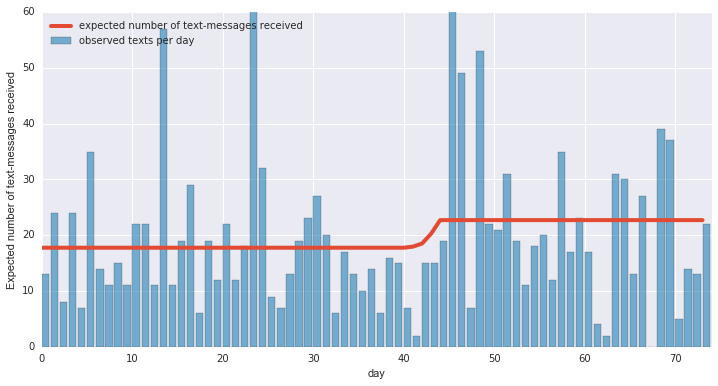

In [27]:
fig = plt.figure(figsize=(12, 6))
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples
    
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N
    
plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color='#E24A33', label='expected number of text-messages received')
plt.xlim(0, n_count_data)
plt.xlabel('day')
plt.ylabel('Expected number of text-messages received')
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color='#348ABD', alpha=0.65, label='observed texts per day')
plt.legend(loc='upper left')

我们可以看到确实突然在44天附近发生了行为变化。我们可以分析下是什么导致了变化（实际上第45天是圣诞节，并且之后我离开了女友，去了多伦多）

##### Exercises
1\.  Using `lambda_1_samples` and `lambda_2_samples`, what is the mean of the posterior distributions of $\lambda_1$ and $\lambda_2$?

In [28]:
(lambda_1_samples.sum() + lambda_2_samples.sum()) / (lambda_1_samples.size + lambda_2_samples.size)

20.229635196557183

2\.  What is the expected percentage increase in text-message rates? `hint:` compute the mean of `lambda_1_samples/lambda_2_samples`. Note that this quantity is very different from `lambda_1_samples.mean()/lambda_2_samples.mean()`.

In [32]:
(lambda_1_samples / lambda_2_samples).mean()

0.78330538666803817

In [33]:
lambda_1_samples.mean()/lambda_2_samples.mean()

0.78206891517101806

3\. What is the mean of $\lambda_1$ **given** that we know $\tau$ is less than 45.  That is, suppose we have been given new information that the change in behaviour occurred prior to day 45. What is the expected value of $\lambda_1$ now? (You do not need to redo the PyMC3 part. Just consider all instances where `tau_samples < 45`.)

In [34]:
idx = tau_samples < 45

lambda_1_samples[idx].mean() 

17.755620664821919

In [35]:
lambda_1_samples.mean()

17.755731798911544

### References


-  [1] Gelman, Andrew. N.p.. Web. 22 Jan 2013. [N is never large enough](http://andrewgelman.com/2005/07/n_is_never_large).
-  [2] Norvig, Peter. 2009. [The Unreasonable Effectiveness of Data](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/35179.pdf).
- [3] Salvatier, J, Wiecki TV, and Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. *PeerJ Computer Science* 2:e55 <https://doi.org/10.7717/peerj-cs.55>
- [4] Jimmy Lin and Alek Kolcz. Large-Scale Machine Learning at Twitter. Proceedings of the 2012 ACM SIGMOD International Conference on Management of Data (SIGMOD 2012), pages 793-804, May 2012, Scottsdale, Arizona.
- [5] Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013. <https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1>.

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()